In [1]:
input_dim = 13166
num_clusters = 18

model_file = "/home/jim/Documents/AI/fact/reproduction/ELDR-reproduction/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt"
pc_matrix_file = "/home/jim/Documents/AI/fact/reproduction/ELDR-reproduction/Bipolar/Data/bipolar_pc.tsv"

import csv
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

os.system("rm *.png")

import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from metrics import metrics, eval_epsilon, similarity
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation
from misc import poly2labels, load

matplotlib.rc("lines", markersize = 2)# Override some default plot parameters

sys.path.insert(0, "../Bipolar/")
from load_vae import load_vae

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file, feature_transform = pc_matrix_file)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# Load Data & Configuration

x = pd.read_csv("../Bipolar/Data/bipolar_rep_scaled.tsv", sep="\t").values

with open("../Bipolar/vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [3]:
# Approximate the original data

matrix = pd.read_csv(pc_matrix_file, sep = "\t", header = None).values

x_full = np.matmul(x, np.transpose(matrix))

In [4]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x_full, D: np.zeros((1, input_dim))})




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



INFO:tensorflow:Restoring parameters from /home/jim/Documents/AI/fact/reproduction/ELDR-reproduction/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


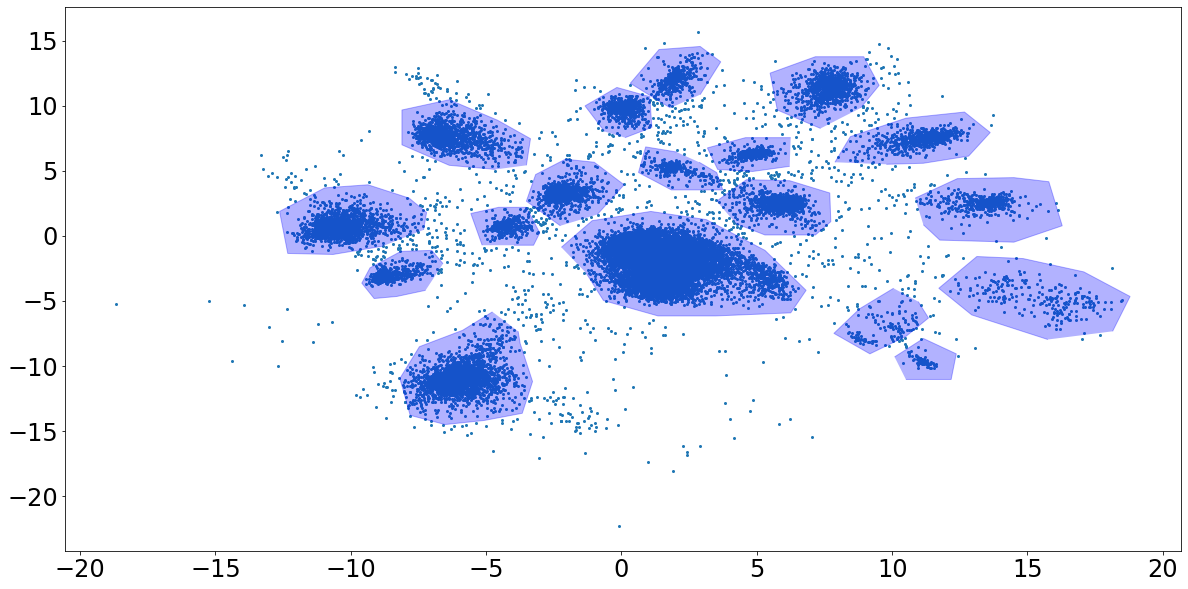

In [5]:
# Visualize the data and the marked clusters
plot_polys(data_rep, all_vertices)

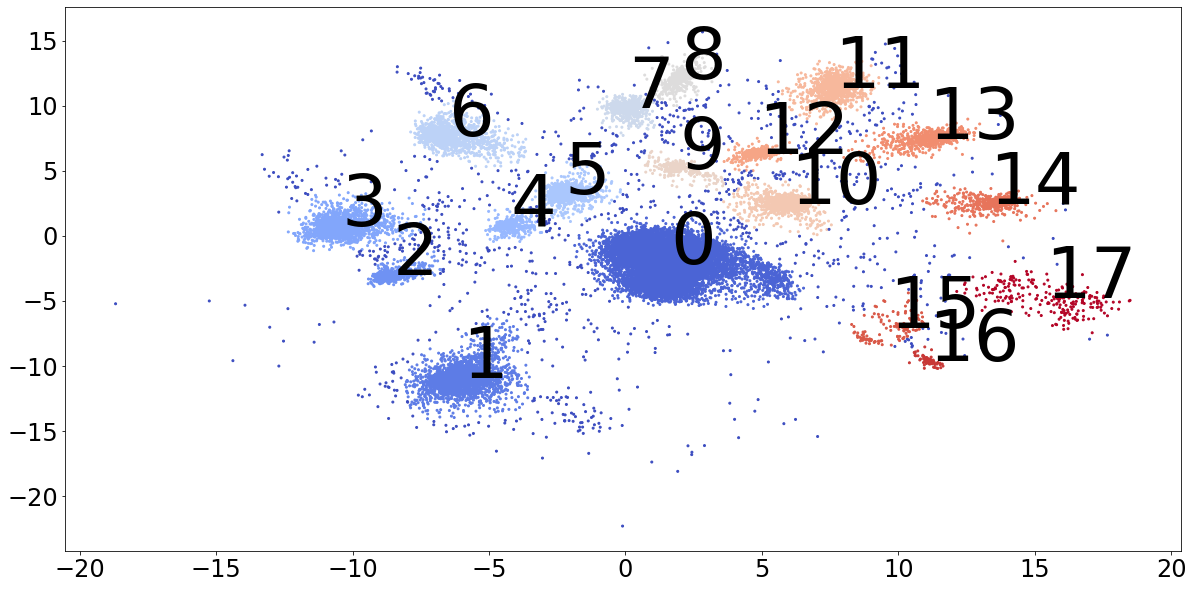

In [6]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x_full, data_rep, num_clusters, labels, name = "bipolar-rep.png")


In [7]:
# Select a subset of the data to use to select the hyper parameters

frac = 0.25

n = x_full.shape[0]

chosen = np.random.choice(n, int(frac * n), replace = False)

x_val = x_full[chosen, :]

indices_val = [[]] * num_clusters
for i in range(num_clusters):
    indices_val[i] = []
    for j in range(int(frac * n)):
        if labels[chosen[j]] == i:
            indices_val[i].append(j)


In [8]:
# Set epsilon for our metrics

epsilon = 0.75

if False:
    os.system("rm epsilon.txt")
    eval_epsilon(load_model, x_full, indices, epsilon)


In [9]:
run = False

# Initialize results 
# Columns are:  K, TGT-correctness, TGT-coverage, DBM-correctness, DBM-coverage
K = [50, 100, 250, 500, 1000, 15000]
if run:
    os.system("rm *.npy")
    os.system("rm out.csv")
    
    out = np.zeros((len(K), 5))

    c = 0
    for k in K:
        out[c, 0] = k
        c += 1

In [10]:
# Compute the group explanations at each of a range of sparsities

if run:

    c = 0
    for k in K:

        # Search for the best setting using a subset of the data for evaluation
        best_val = 0.0
        for lg in [0.0, 300, 625, 1250, 2500]:
            for trial in range(5):

                deltas = explain(load_model, means, centers, learning_rate = 0.0005, consecutive_steps = 5, lambda_global = lg)
                a, b = metrics(load_model, x_val, indices_val, deltas, epsilon, k = k)

                val = np.mean(a)

                if val > best_val:
                    best_val = val
                    np.save("deltas" + str(k) + ".npy", deltas)

                os.system("rm -rf explanation")
                
        # Evaluate the best configuration on the full data
        deltas = np.load("deltas" + str(k) + ".npy")
        a, b = metrics(load_model, x_full, indices, deltas, epsilon, k = k)
        out[c, 1] = np.mean(a)
        out[c, 2] = np.mean(b)

        c += 1
        

In [11]:
# Evaluate DBM 

if run:
    exp_mean = np.zeros((num_clusters - 1, input_dim))
    for i in range(num_clusters - 1):
        exp_mean[i, :] = means[i + 1] - means[0]

    c = 0
    for k in K:
        a, b = metrics(load_model, x_full, indices, exp_mean, epsilon, k = k)

        out[c, 3] = np.mean(a)
        out[c, 4] = np.mean(b)

        c += 1
    

In [12]:
# Save results
if run:
    np.savetxt("out.csv", out, delimiter = ",")
else:
    out = np.loadtxt("out.csv", delimiter = ",")
    
print(out)


[[5.00000000e+01 5.94324527e-01 8.48603747e-01 1.67580168e-01
  4.43517202e-01]
 [1.00000000e+02 7.67456447e-01 9.22338612e-01 2.86822688e-01
  6.43923859e-01]
 [2.50000000e+02 8.72163210e-01 9.69100160e-01 5.96030171e-01
  8.58535988e-01]
 [5.00000000e+02 9.04756605e-01 9.70316425e-01 7.96424264e-01
  9.30983617e-01]
 [1.00000000e+03 9.27131700e-01 9.62039357e-01 8.90947163e-01
  9.61968214e-01]
 [1.50000000e+04 9.37620235e-01 9.14341995e-01 9.60040106e-01
  9.62735140e-01]]


In [13]:
# Evaluate the stability of TGT as it finds sparser explanations
# Warning:  check the order of the elements of K to ensure the correct comparison is being made
S = np.zeros((len(K) - 1, 2))

for c in range(len(K) - 1):
    k_more = K[c]
    k_less = K[c + 1]
    
    d_more = np.load("deltas" + str(k_more) + ".npy")
    d_less = np.load("deltas" + str(k_less) + ".npy")

    res = np.ones((num_clusters, num_clusters))
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                e_more = load(d_more, k_more, i, j)
                e_less = load(d_less, k_less, i, j)
                res[i, j] = similarity(e_more, e_less)
        
    S[c, 0] = k_more
    S[c, 1] = np.mean(res)
    c += 1



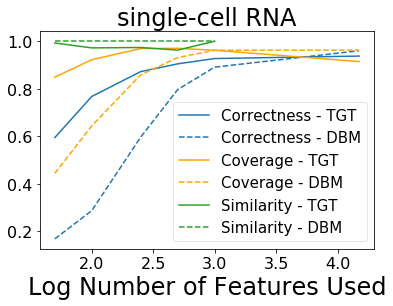

In [14]:
# Plot the comparison of TGT to DBM based on our metrics at varying degrees of sparsity

import matplotlib
matplotlib.rc("xtick", labelsize = 16)
matplotlib.rc("ytick", labelsize = 16)
matplotlib.rc("axes", titlesize = 24)
matplotlib.rc("axes", labelsize = 24)
#matplotlib.rc("lines", markersize = 16)

x_1 = np.log10(out[:, 0])
x_2 = np.log10(S[:, 0])

plt.plot(x_1, out[:, 1], c = "C0", label = "Correctness - TGT")
plt.plot(x_1, out[:, 3], ls = "--", c= "C0", label = "Correctness - DBM")
plt.plot(x_1, out[:, 2], c = "orange", label = "Coverage - TGT")
plt.plot(x_1, out[:, 4], ls = "--", color = "orange", label = "Coverage - DBM")
plt.plot(x_2, S[:, 1], color = "C2", label = "Similarity - TGT")
plt.plot(x_2, np.ones((len(K) - 1)), ls = "--", color = "C2", label = "Similarity - DBM")

#plt.ylabel("Metric")
plt.xlabel("Log Number of Features Used")
plt.title("single-cell RNA")

plt.legend(prop={"size":15}, framealpha = 0.5)

plt.savefig("bipolar-tradeoff.png", bbox_inches='tight')
plt.show()
plt.close()